[Scanpy Tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
[Anndata documentation](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html#anndata.AnnData)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80)

wolock data need to trim off data first 18 col are metadata
`cut -d$'\t' GSE132151_bone_marrow_stroma.counts.tsv -f 1-18 > GSE132151_bone_marrow_stroma.metadata.tsv`
`cut -d$'\t' GSE132151_bone_marrow_stroma.counts.tsv -f 1,19- > GSE132151_bone_marrow_stroma.trimmed.tsv`


In [41]:
def read_raw_counts(tsv, ignore_lines = 1, transpose = True):
    '''
    read .tsv raw counts with columns = cells; row = genes
    works specially for nature 2019 data (ignore_line = 1), nature 2019 mice stroma (ignore_line = 0)
    
    input: .tsv file
    ingnore_lines: does not count header. ignore the second line and so on. (natuer 2019 human has library line)
    return anndata fitting scanpy
    '''
    # read raw counts data
    adata = sc.read(tsv, cache = True)
    
    # remove first row "Library", save as obs
    if ignore_lines > 0:
        for i in range(ignore_lines):
            name = adata.obs.index[i]
            print(name)
            adata.var[name] = adata.X[i]
        # transpose to make var = genes; obs = cells;
    if transpose:
        adata = adata[ignore_lines:, :].copy().T 
    
    return(adata)

In [5]:
# import annotation
from scSecretome.annot import *

In [12]:
def benchmarking(adata, species = 'human'):
    # number of UMI counts per cell
    adata.obs['n_counts'] = adata.X.sum(axis=1)
    
    # number of genes per cell (non-zero)
    adata.obs['n_genes'] = np.count_nonzero(adata.X, axis = 1)
    
    # find mitochondiral genes and count
    if species == 'human':
        mito_genes = adata.var_names.str.startswith('MT-')
    else:
        mito_genes = adata.var_names.str.startswith('mt-')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    
    # % housekeepers present
    housekeeper = housekeeping()
    if species != 'human':
        converter = human_mouse_homolog()
        housekeeper = converter.loc[converter['Human'].isin(housekeeper), 'Mouse'].tolist()
    # not all housekeepers are present
    hk = list(set(housekeeper).intersection(set(adata.var.index)))
    adata.obs['percent_housekeeper'] = np.count_nonzero(adata[:, hk].X, axis=1) / len(housekeeper)
    
    # % lineage specific genes showing up
    for g in read_haemapedia(species = species).groupby('Lineage'):
        ln = list(set(g[1]['Gene Symbol'].values).intersection(set(adata.var.index)))
        adata.obs[g[0]] = np.count_nonzero(adata[:, ln].X, axis=1)/g[1].shape[0]
    

# Wolock 2019, Mapping Distinct Bone Marrow Niche Populations and Their Differentiation Paths

In [43]:
wo = read_raw_counts('/home/hsher/wolock2019_stroma/GSE132151_bone_marrow_stroma.trimmed.tsv', ignore_lines = 0, transpose = False)

... reading from cache file cache/home-hsher-wolock2019_stroma-GSE132151_bone_marrow_stroma.trimmed.h5ad


In [44]:
benchmarking(wo, species = 'mouse')

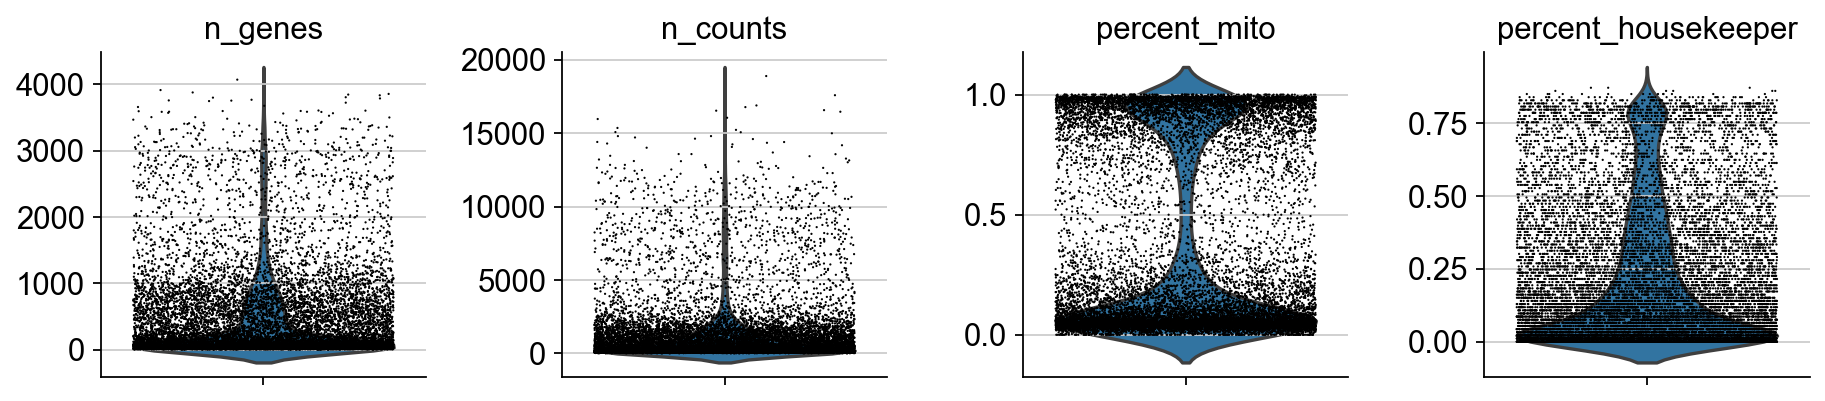

In [45]:
sc.pl.violin(wo, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'],
             jitter=0.4, multi_panel=True)
# they filter n_count > 500; mito < 30

# A comprehensive single cell transcriptional landscape of human hematopoietic progenitors, Nature 2019

In [16]:
from os import listdir
file_list = listdir('/home/hsher/nature2019_sc/raw_counts/')
# the paper contain data from two patients
sample_two = [s for s in file_list if 'Lin' in s]
sample_one = [s for s in file_list if 'Lin' not in s]

In [17]:
sample_one # sorted based on FACs, and processed in parallele

['GSM3305364_CMP.raw_counts.tsv',
 'GSM3305363_MEP.raw_counts.tsv',
 'GSM3305365_GMP.raw_counts.tsv',
 'GSM3305362_PreBNK.raw_counts.tsv',
 'GSM3305360_MPP.raw_counts.tsv',
 'GSM3305359_HSC.raw_counts.tsv',
 'GSM3305361_MLP.raw_counts.tsv']

In [18]:
sample_two # sorted by FACs too

['GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv',
 'GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv',
 'GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv',
 'GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv']

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305364_CMP.raw_counts.h5ad
Library
GSM3305364_CMP.raw_counts.tsv


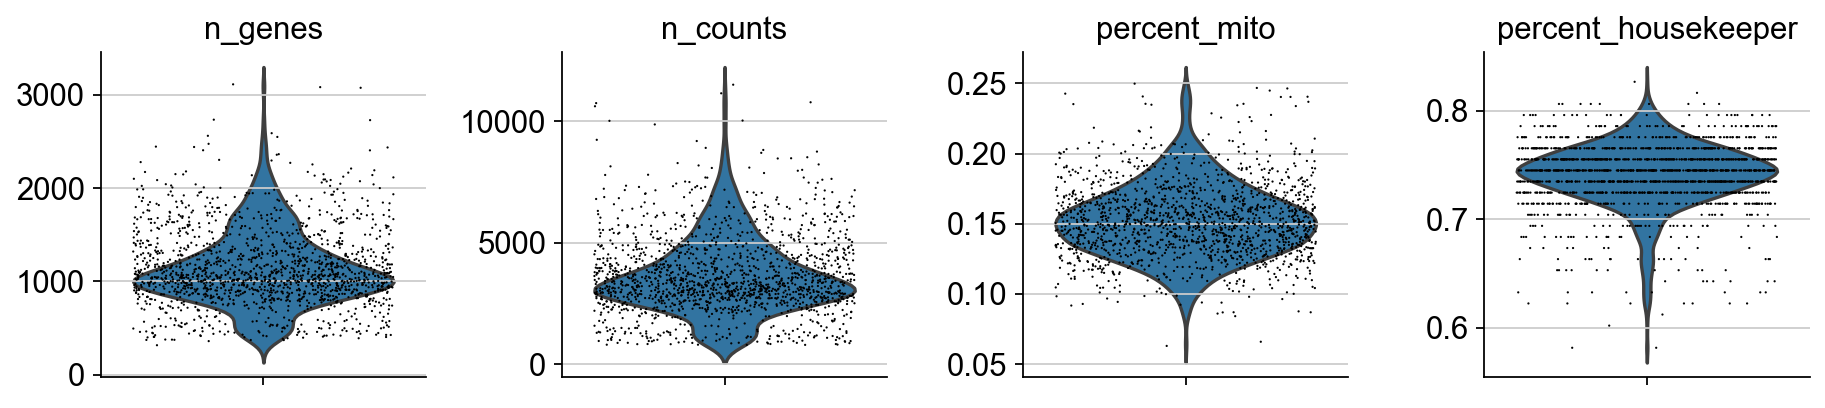

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305363_MEP.raw_counts.h5ad
Library
GSM3305363_MEP.raw_counts.tsv


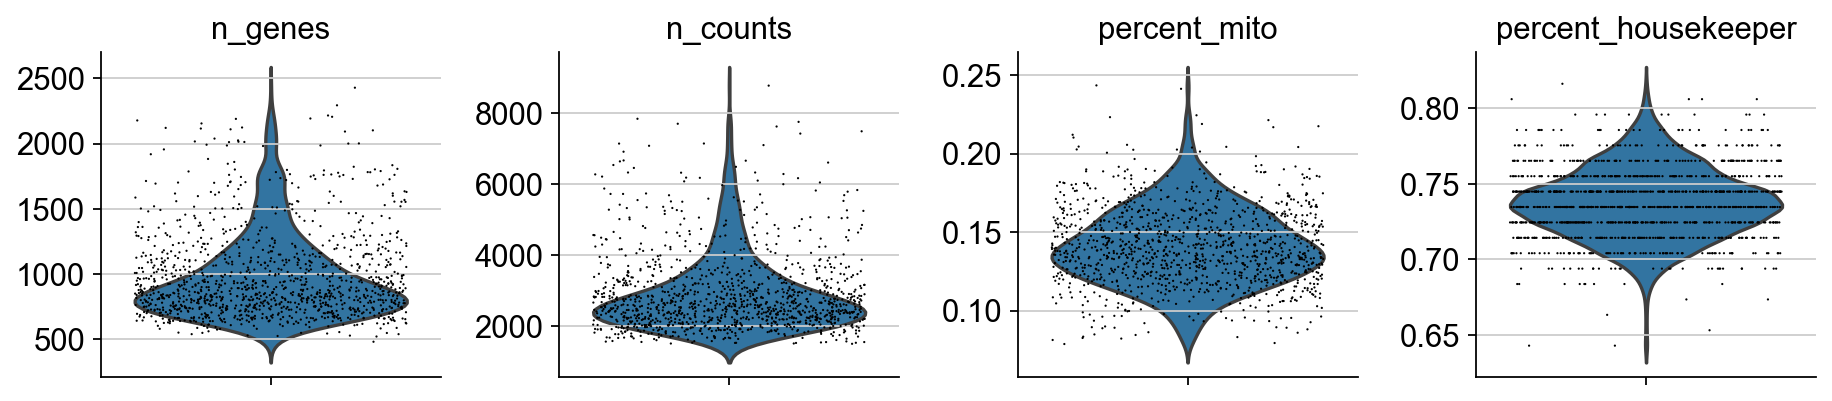

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305365_GMP.raw_counts.h5ad
Library
GSM3305365_GMP.raw_counts.tsv


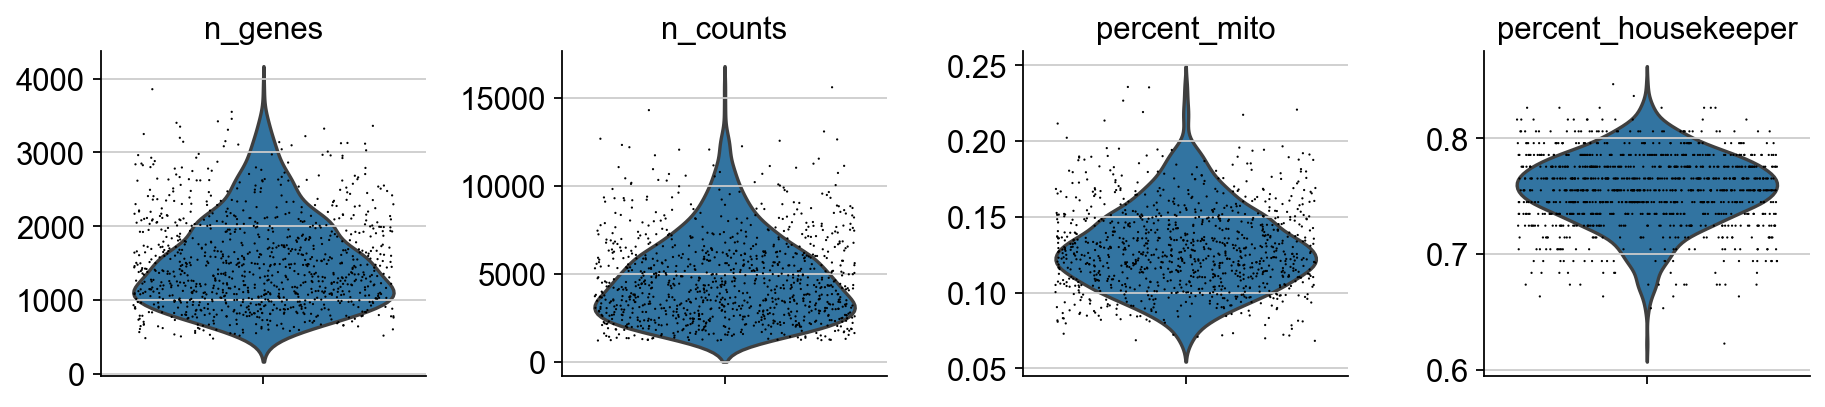

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305362_PreBNK.raw_counts.h5ad
Library
GSM3305362_PreBNK.raw_counts.tsv


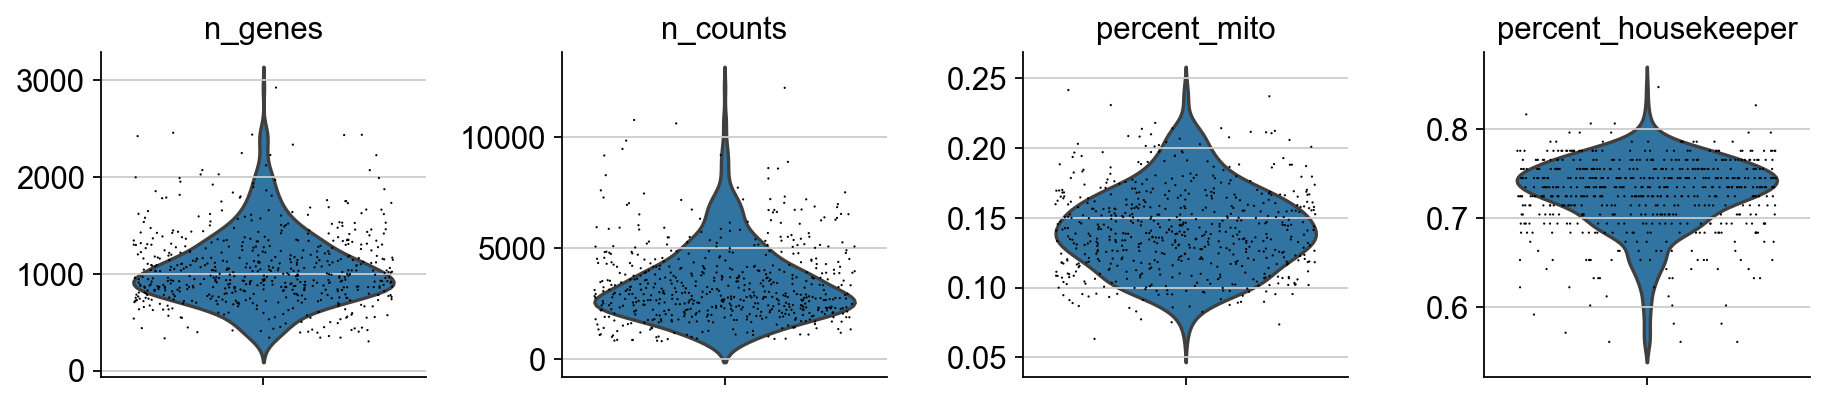

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305360_MPP.raw_counts.h5ad
Library
GSM3305360_MPP.raw_counts.tsv


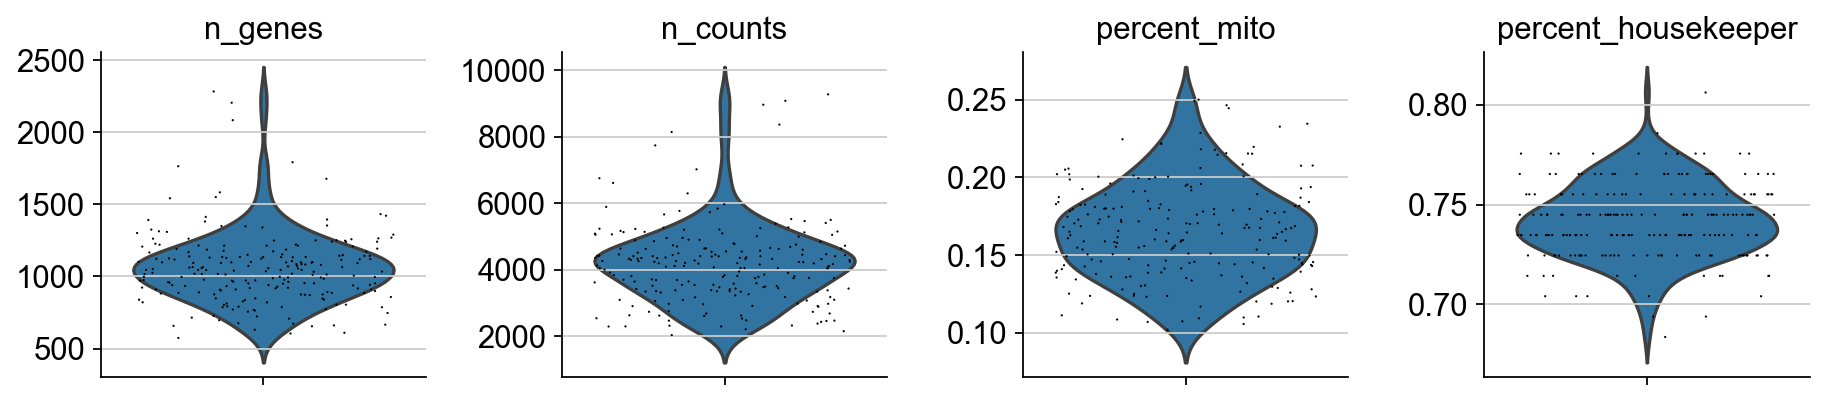

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305359_HSC.raw_counts.h5ad
Library
GSM3305359_HSC.raw_counts.tsv


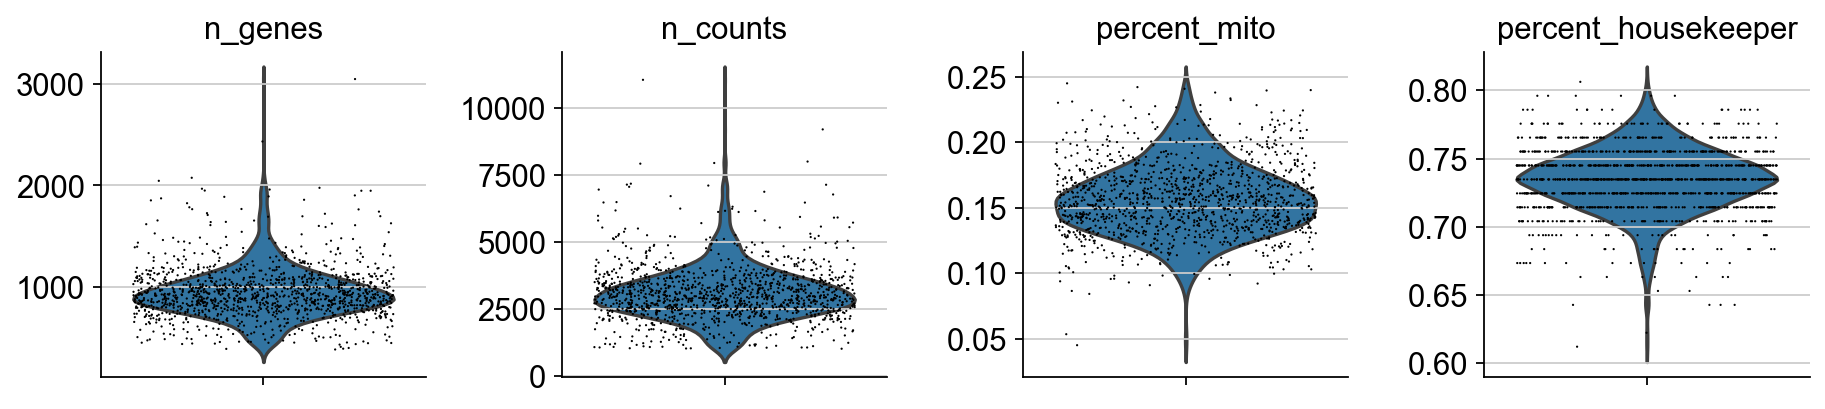

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305361_MLP.raw_counts.h5ad
Library
GSM3305361_MLP.raw_counts.tsv


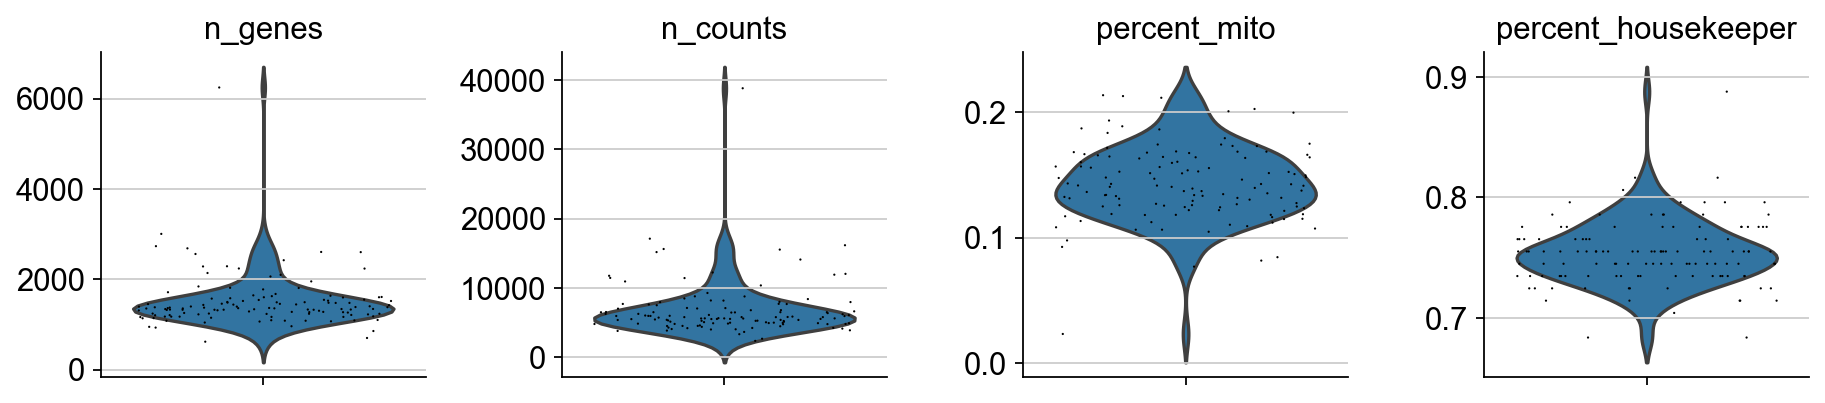

In [46]:
for s in sample_one:
    # run benchmarking
    d = read_raw_counts('/home/hsher/nature2019_sc/raw_counts/'+s)
    benchmarking(d)
    
    # see benchmarking result
    print(s)
    sc.pl.violin(d, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'], jitter=0.4, multi_panel=True)

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305369_LinNegCD34NegCD164low.raw_counts.h5ad
Library
GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv


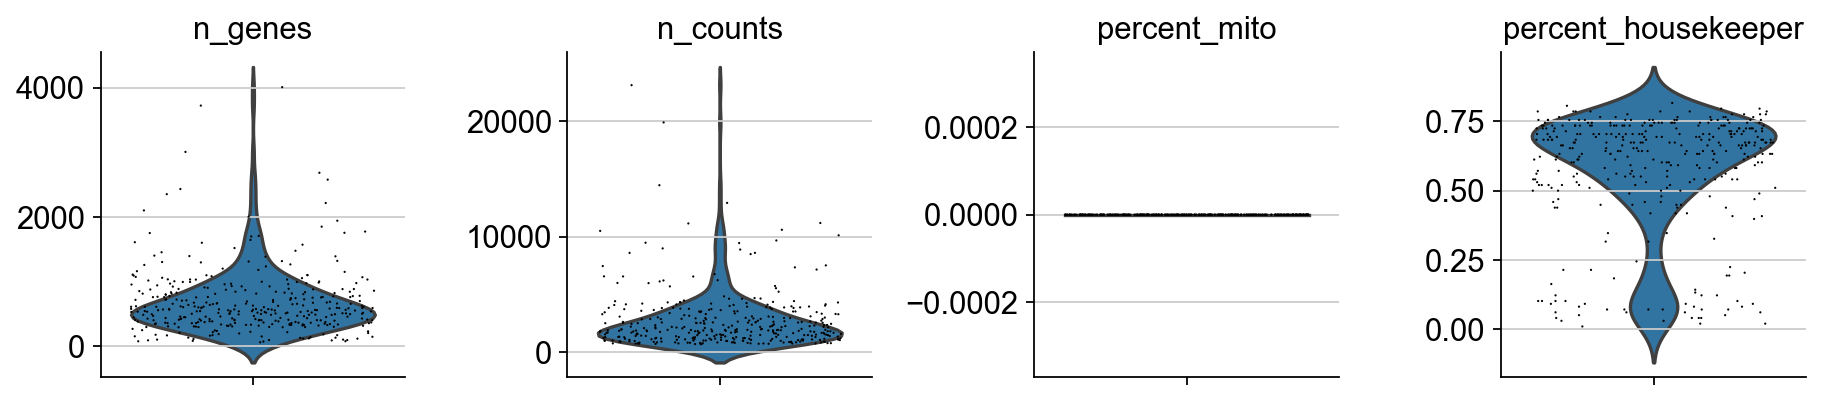

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305367_LinNegCD34NegCD164high.raw_counts.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Library
GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv


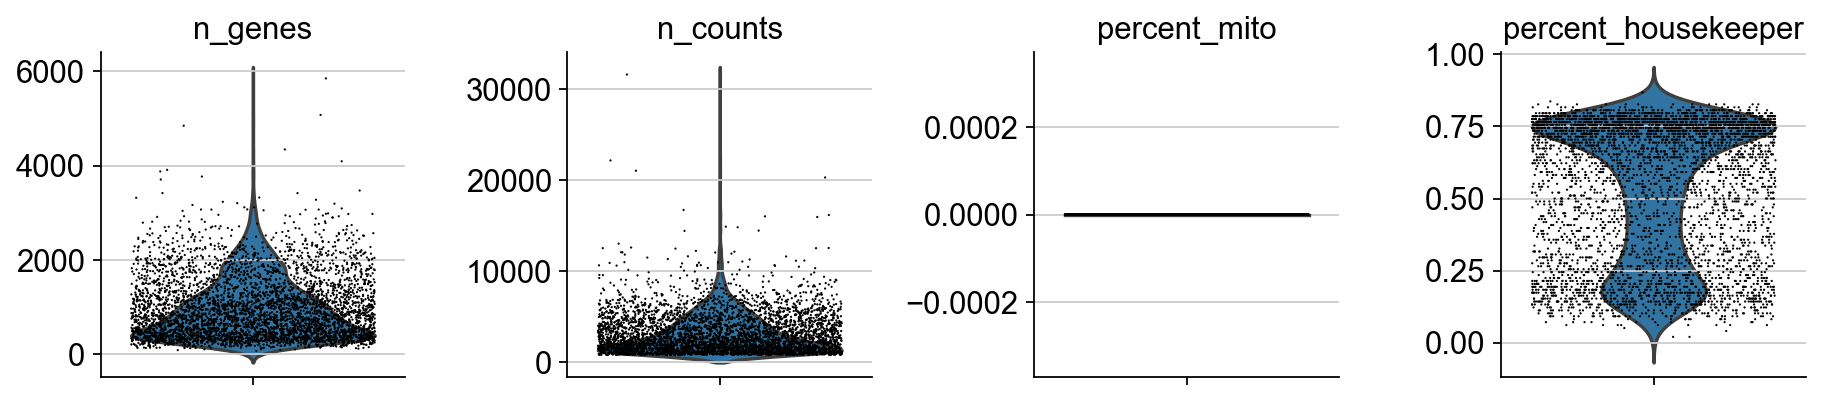

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305366_LinNegCD34PosCD164Pos.raw_counts.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Library


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv


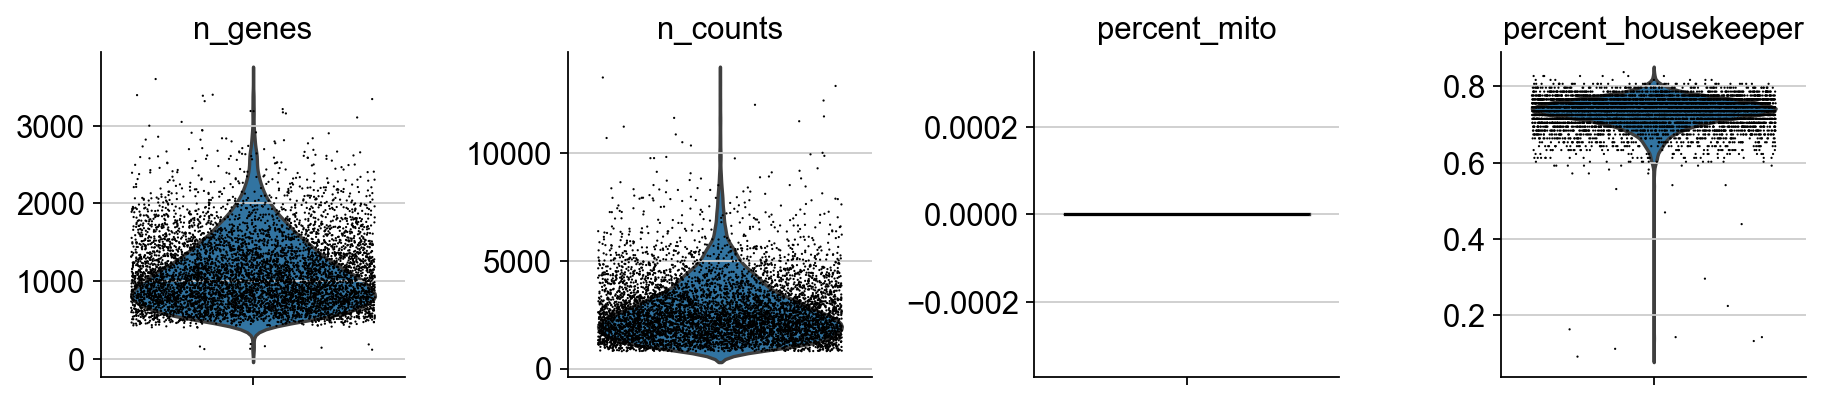

... reading from cache file cache/home-hsher-nature2019_sc-raw_counts-GSM3305368_LinNegCD34lowCD164high.raw_counts.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Library
GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv


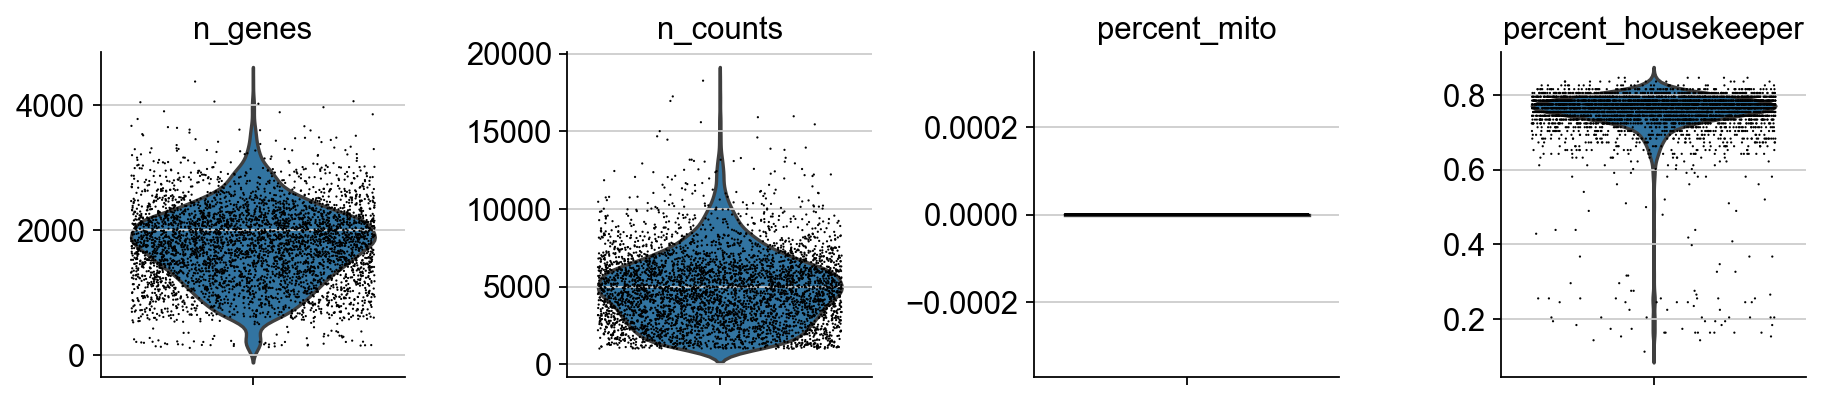

In [47]:
for s in sample_two:
    # run benchmarking
    d = read_raw_counts('/home/hsher/nature2019_sc/raw_counts/'+s, ignore_lines = 1, transpose = True)
    benchmarking(d)
    
    # see benchmarking result
    print(s)
    sc.pl.violin(d, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'], jitter=0.4, multi_panel=True)

In [51]:
d.var.loc[d.var.index.str.contains('MT-')] # no mitocondrial genes?? weird
# I checked the original file and still, no MT-

Empty DataFrame
Columns: []
Index: []

# Single cell transcriptome profiling of the bone marrow niche at steady state and under stress conditions

In [27]:
sample_three = listdir('/home/hsher/nature2019_mice_niche/') # mice stroma data nature 2019

In [31]:
sample_three # only use 2 and 5

['GSM3494770_vecad-5fu.counts.raw.txt',
 'GSM3494771_vecad-ctrl.counts.raw.txt',
 'GSM3494768_lepr-5fu.counts.raw.txt',
 'GSE123078_RAW.tar',
 'GSM3494769_lepr-ctrl.counts.raw.txt']

In [32]:
sample_three.remove('GSE123078_RAW.tar')

In [33]:
sample_three

['GSM3494770_vecad-5fu.counts.raw.txt',
 'GSM3494771_vecad-ctrl.counts.raw.txt',
 'GSM3494768_lepr-5fu.counts.raw.txt',
 'GSM3494769_lepr-ctrl.counts.raw.txt']

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494770_vecad-5fu.counts.raw.h5ad
GSM3494770_vecad-5fu.counts.raw.txt


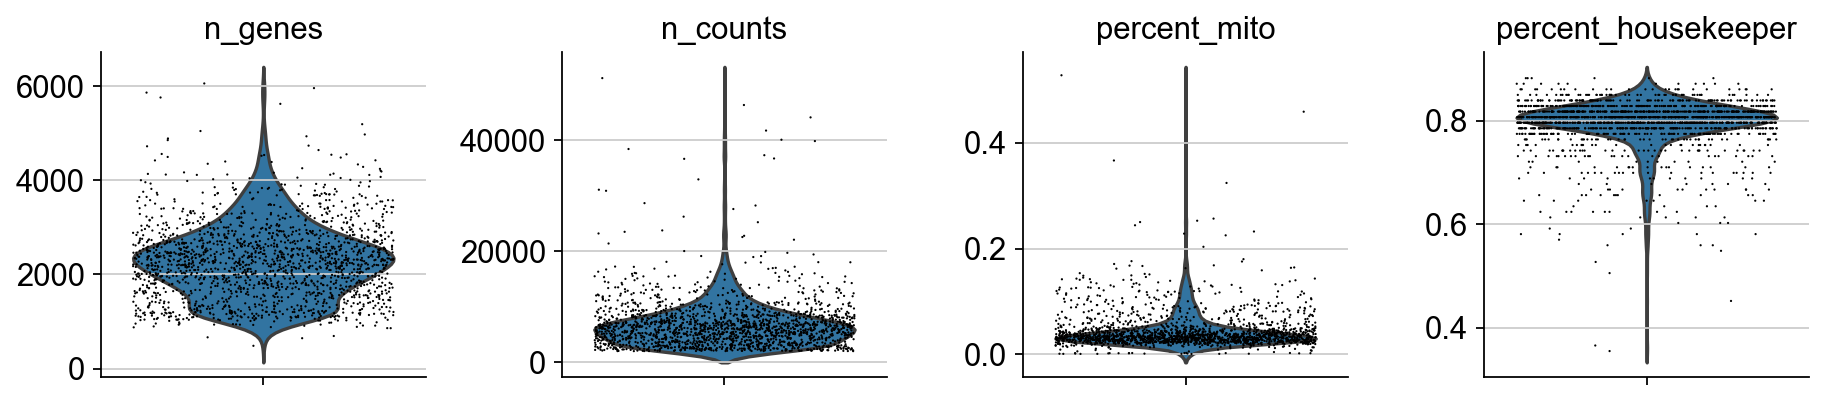

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494771_vecad-ctrl.counts.raw.h5ad
GSM3494771_vecad-ctrl.counts.raw.txt


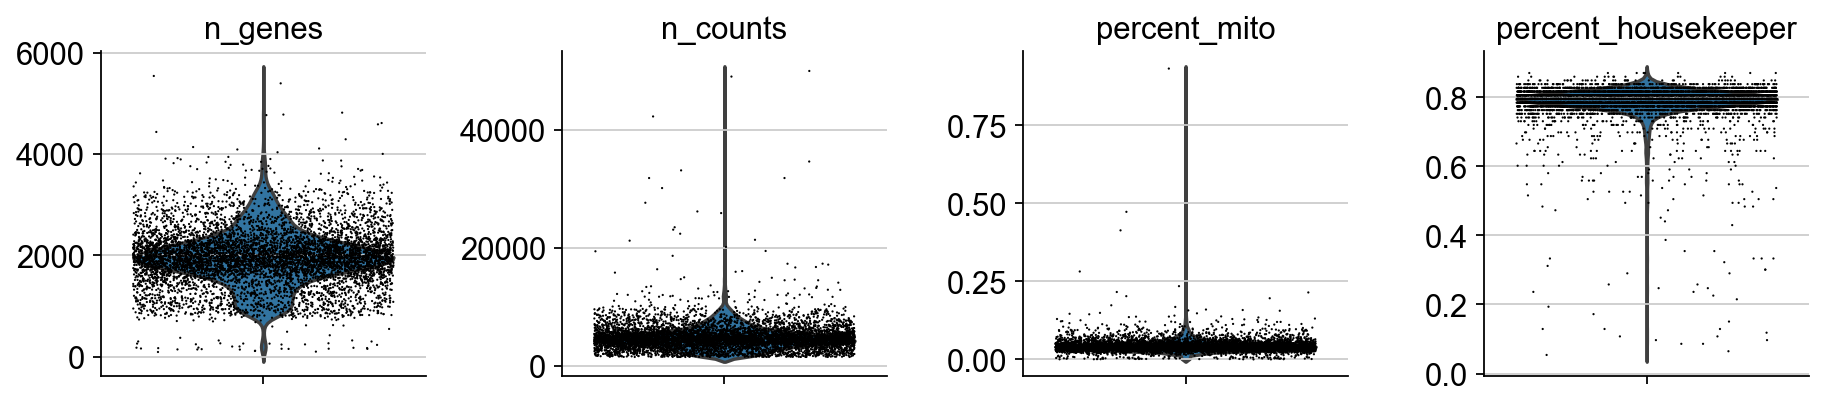

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494768_lepr-5fu.counts.raw.h5ad
GSM3494768_lepr-5fu.counts.raw.txt


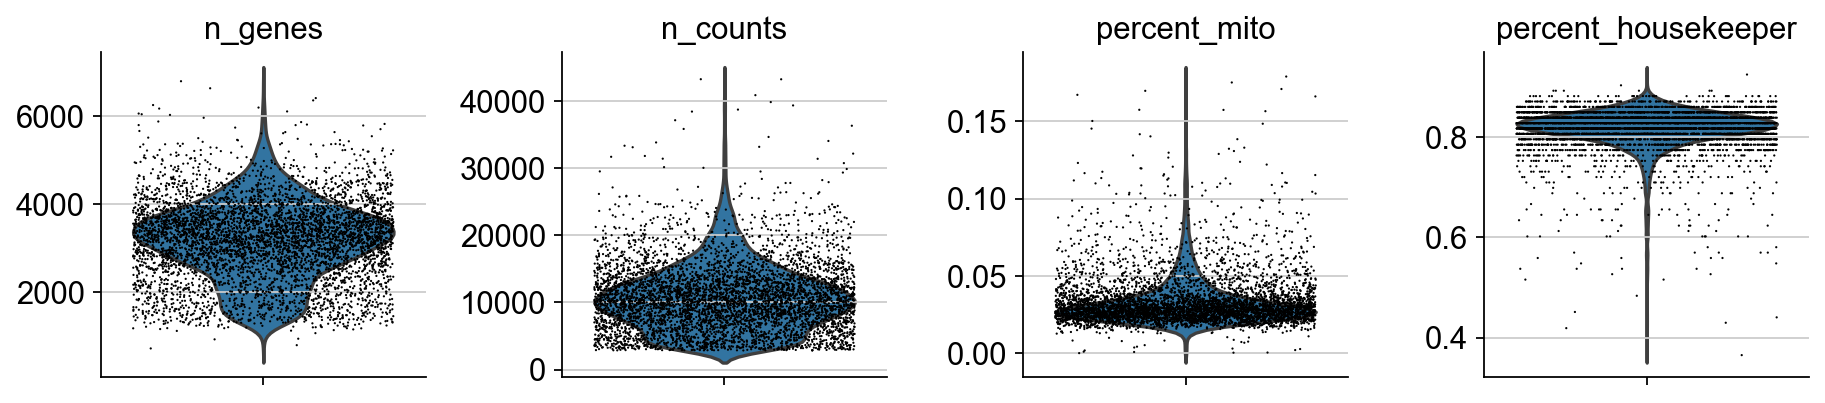

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494769_lepr-ctrl.counts.raw.h5ad
GSM3494769_lepr-ctrl.counts.raw.txt


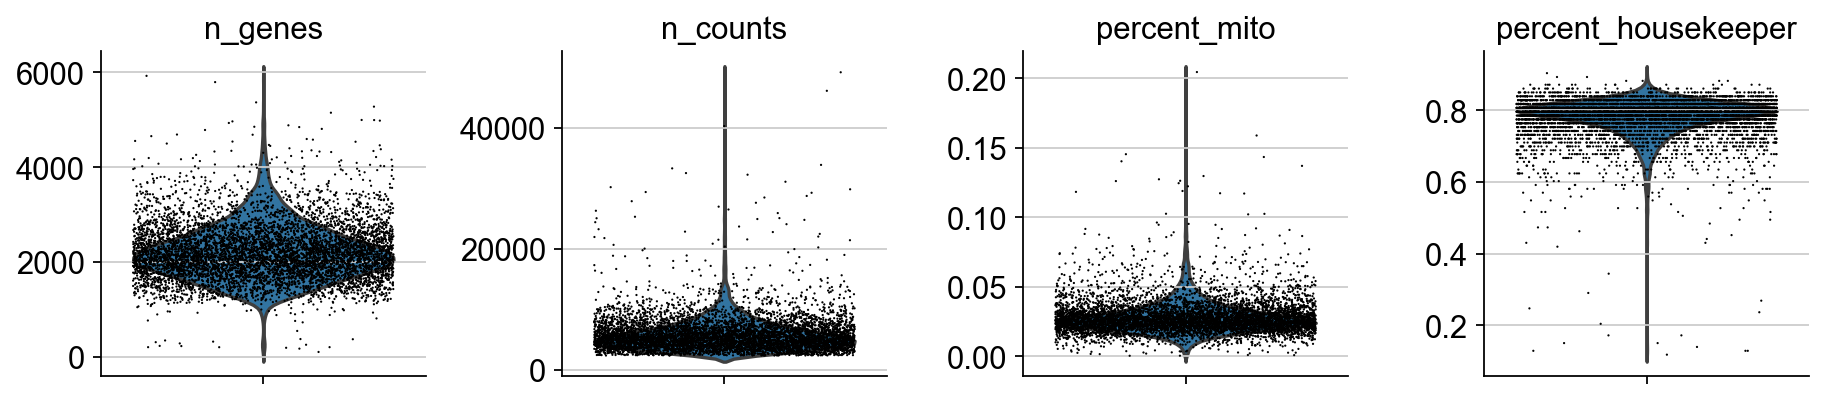

In [52]:
for s in sample_three:
    # run benchmarking
    d = read_raw_counts('/home/hsher/nature2019_mice_niche/'+s, ignore_lines = 0, transpose = True)
    benchmarking(d, species = 'mouse')
    
    # see benchmarking result
    print(s)
    sc.pl.violin(d, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'], jitter=0.4, multi_panel=True)

In [148]:
sc.pp.recipe_seurat(d)

filtered out 10969 genes that are detected in less than 3 cells


In [160]:
sc.pp.neighbors(d)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03.50) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [164]:
sc.tl.umap(d)

computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:03.54) --> added
    'X_umap', UMAP coordinates (adata.obsm)


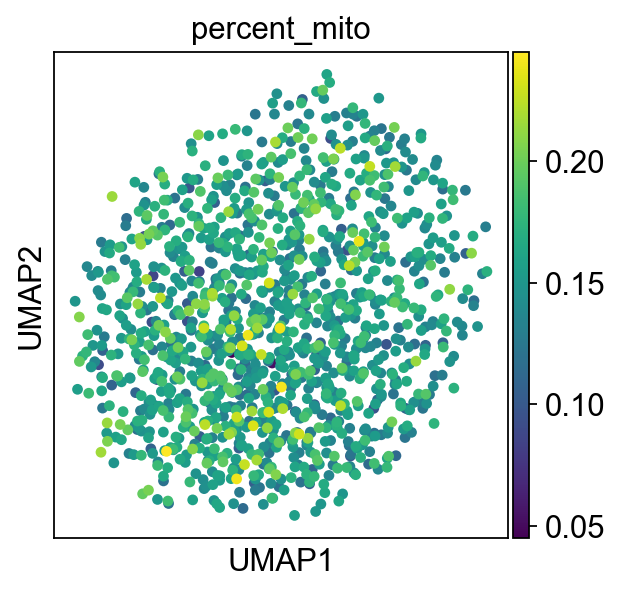